# Momento de Retroalimentación: Módulo 2 Análisis y Reporte sobre el desempeño del modelo. (Portafolio Análisis)
### Facundo Vecchi A01283666

##### Importaciones de librerias

In [2]:
# Uso General
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Metricas y utilidades
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mlxtend.evaluate import bias_variance_decomp
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split

# Modelos
from sklearn.linear_model import LogisticRegression

##### Importacion de datos y creacion de train y test dataframes

In [3]:
# Importacion de Datos

cols = ["Class", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
        "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue", "OD280/OD315 of diluted wines", "Proline"]
data = pd.read_csv("wine.data", header=None, names=cols)

# Separacion de datos
scaler = StandardScaler()
X = scaler.fit_transform(
    data.drop(columns=["Class", "Malic acid", "Ash", "Alcalinity of ash", "Magnesium", "Total phenols", "Flavanoids",
                       "Nonflavanoid phenols", "Proanthocyanins", "Color intensity", "Hue",
                       "OD280/OD315 of diluted wines", "Proline"], axis=1))
y = data.Class.values



## Introduccion
En el portafolio de implementacion se intento encontrar cual seria el mejor de 8 modelos para predecir el tipo de vino del Wine dataset. La conclusion de esa implementacion fue que el mejor modelo para el dataset de wine es el de Random Forest Classifier de Sklearn. El proposito de este analisis es utilizar un modelo y obtener su sesgo, varianza y diagnosticar su nivel de ajuste (underfit, fit u overfit) y finalmente aplicar tecnicas de refinacion

### Modelo a utilizar
* **Regresion logistica**

Para este analisis, se utilizara el modelo de Regresion Logistica, aunque se concluyo que el mejor modelo es Random Forest, como obtuvo una precision de 100% no tiene mucho sentido utilizarlo para este analisis. Se escogio Regresion logisitica ya que es un modelo que vimos en clase y es mas simple de manipular los resultados con los parametros, ya que no depende de la aleatoridad.

## Modelo base
Primero vamos a observar el modelo base el cual tendra los siguiente parametros:
* Caracteristicas a utilizarze:
    * Cantidad de caracteristicas: 1
    * Nombres:
        * Alcohol
* Parametros relevantes por defecto de Regresion Lineal:
    * penalty = l2
    * solver = lbfgs
    * max_iter = 100
    * C = 1.0

Se empieza utilizando una sola caracteristica y los parametros por defecto para tener espacio de mejora en el modelo.

### Resultados
* Sesgo Alto
* Varianza baja
* Underfit

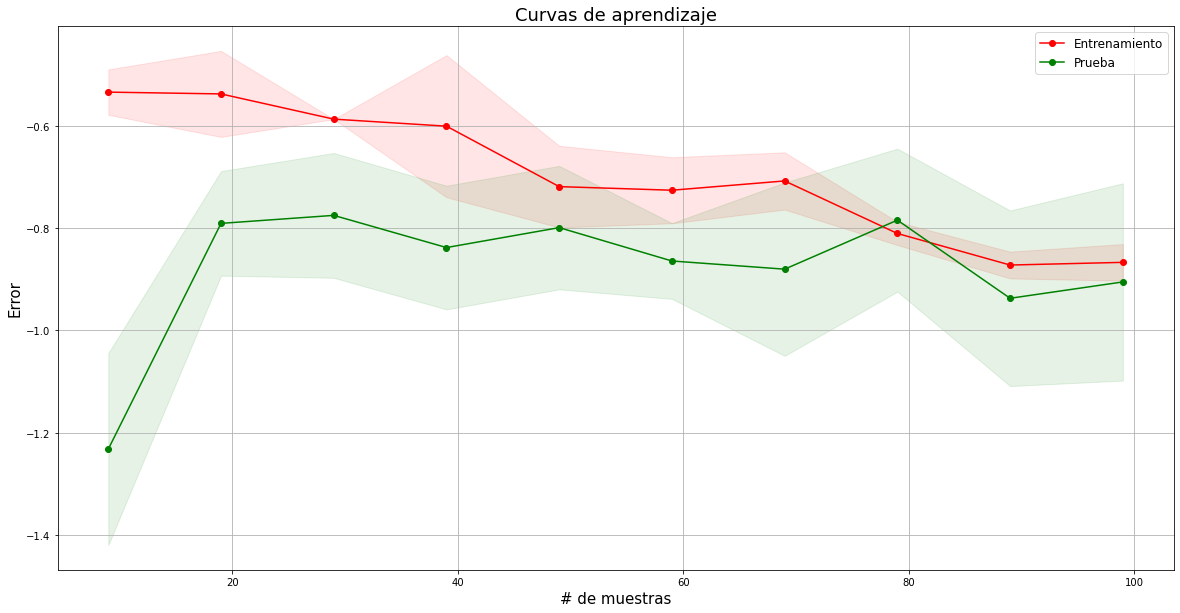

In [4]:
# Separacion de datos de entrenamiento y prueba
X_train_, X_test_, y_train_, y_test_ = train_test_split(X, y, test_size=0.30, random_state=42)

lr_base = LogisticRegression()

# la funcion bias_variance_decomp calcula la perdida promedio esperada, la varianza promedio y el sesgo promedio del modelo
# utilizando diferentes porciones de los dataframes y el modelo proporcionados
avg_e_loss_base, avg_bias_base, avg_var_base = bias_variance_decomp(lr_base, X_train_, y_train_, X_test_, y_test_,
                                                                    loss="0-1_loss",
                                                                    num_rounds=200, random_seed=42)
results_base = pd.Series(data=[avg_e_loss_base, avg_bias_base, avg_var_base],
                    index=["Error total promedio", "Sesgo promedio", "Varianza promedio"])

train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(lr_base, X_train_, y_train_, return_times=True,
                                                                      train_sizes=np.linspace(0.1, 1.0, 10),
                                                                      scoring='neg_mean_squared_error')
figure = plt.figure()
figure.set_size_inches(20, 10)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Prueba")
plt.legend(loc="best", fontsize=12)
plt.xlabel("# de muestras", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.title("Curvas de aprendizaje", fontsize=18);


In [5]:
print(pd.DataFrame(results_base).T.to_string(index=False))

 Error total promedio  Sesgo promedio  Varianza promedio
             0.298426        0.296296           0.076759


Como se puede observar en la grafica, ambas lineas de entrenamiento y prueba se acercan casi que al instante mientras aumenta el numero de muestras, esto es un claro indicador de que el modelo tiene un sesgo alto.
Para confirmar lo visto en la grafica, se calculo el sesgo y varianza promedio del modelo, el cual tambien se muestra alto indicando que este modelo tiene underfit.

## Splits de entrenamiento y pruebas
Antes de empezar a modificar los parametros, veremos cuanto cambia la precision del modelo, junto con el sesgo y su varianza cuando se utilizan diferentes porcentajes para dividir el dataset. </br>
Para lograr esto, se va a calcular y graficar la precision del modelo, su error total, varianza y sesgo utilizando un porcentaje de 10% a 80% de entrenamiento en pasos de 10%. (En total se entrenarian 8 modelos ya que no tiene mucho sentido incrementar el porcentaje de entrenamiento aun mas ya que no se tendrian datos para validar el modelo)

### Resultados
* Split a utilizar: 80%-20%

In [6]:
train_scores = []
test_scores = []
e_loss_scores = []
avg_bias_scores = []
avg_var_scores = []
train_sizes_ = ["Entrenamiento"]
test_sizes_ = ["Prueba"]

n_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
for n in n_values:
    # Se entran un modelo nuevo, se predice tanto el training set como el testing set y se
    # calcula el error total, sesgo y varianza, estos son guardados en listas para despues ser graficados.
    lr = LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=n, random_state=42)
    train_sizes_.append(X_train.shape[0])
    test_sizes_.append(X_test.shape[0])
    lr.fit(X_train, y_train)
    train_scores.append(accuracy_score(y_train, lr.predict(X_train)))
    test_scores.append(accuracy_score(y_test, lr.predict(X_test)))
    avg_e_loss, avg_bias, avg_var = bias_variance_decomp(lr, X_train, y_train, X_test, y_test, loss="0-1_loss",
                                                         random_seed=42)
    e_loss_scores.append(avg_e_loss)
    avg_bias_scores.append(avg_bias)
    avg_var_scores.append(avg_var)


                                        Cantidad de muestras
               10%-90%  20%-80%  30%-70%  40%-60%  50%-50%  60%-40%  70%-30%  80%-20%
Entrenamiento       17       35       53       71       89      106      124      142
       Prueba      161      143      125      107       89       72       54       36


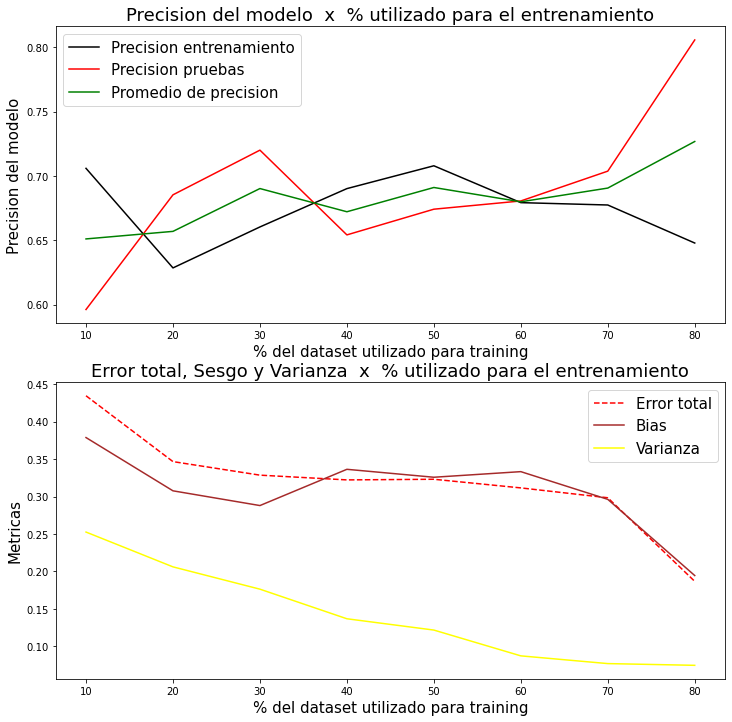

In [7]:
figure, axis = plt.subplots(2)
figure.set_size_inches(12, 12)
score_means = np.mean([train_scores, test_scores], axis=0)
axis[0].plot(range(10, 90, 10), train_scores, color="black", label="Precision entrenamiento")
axis[0].plot(range(10, 90, 10), test_scores, color="r", label="Precision pruebas")
axis[0].plot(range(10, 90, 10), score_means, color="g", label="Promedio de precision")
axis[0].set_title("Precision del modelo  x  % utilizado para el entrenamiento", fontsize=18)
axis[0].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[0].set_ylabel("Precision del modelo", fontsize=15)
axis[0].legend(fontsize=15)

axis[1].plot(range(10, 90, 10), e_loss_scores, "red", label="Error total", linestyle="dashed")
axis[1].plot(range(10, 90, 10), avg_bias_scores, "brown", label="Bias")
axis[1].plot(range(10, 90, 10), avg_var_scores, "yellow", label="Varianza")
axis[1].set_title("Error total, Sesgo y Varianza  x  % utilizado para el entrenamiento", fontsize=18)
axis[1].set_xlabel("% del dataset utilizado para training", fontsize=15)
axis[1].set_ylabel("Metricas", fontsize=15)
axis[1].legend(fontsize=15)

print("                                        Cantidad de muestras")
sizes = pd.DataFrame(data= [train_sizes_, test_sizes_], columns=["","10%-90%", "20%-80%", "30%-70%", "40%-60%", "50%-50%", "60%-40%", "70%-30%", "80%-20%"])
print(sizes.to_string(index=False))

Observando las graficas podemos concluir que el mejor split parece ser el de 80%-20% ya que es en donde el modelo tiene la mayor precision promedio y la menor varianza, sesgo y error total, por lo que se concluye que este split es el mas estable y el que mejor utiliza el modelo para ajustarse al dataset.

## Refinacion del modelo
Utilizando lo descubierto anteriormente se utilizaran tecnicas de refinacion para mejorar la precision, error, sesgo y varianza del modelo. Sabiendo que el modelo tiene un sesgo alto, indicando underfitting, se van a incrementar la cantidad de caracteristicas que se utilizaran para entrenar el modelo y se modificaran los parametros del modelo para buscar mejorar el modelo aun mas.

### Incremento de caracteristicas
* Caracteristicas a utilizarze:
    * Cantidad de caracteristicas: 13
    * Caracteristicas:
        * Alcohol
        * Malic acid
        * Ash
        * Alcalinity of ash
        * Magnesium
        * Total phenols
        * Flavanoids
        * Nonflavanoid phenols
        * Proanthocyanins
        * Color intensity
        * Hue
        * OD280/OD315 of diluted wines
        * Proline
* Parametros relevantes por defecto de Regresion Lineal:
    * penalty = l2
    * solver = lbfgs
    * max_iter = 100
    * C = 1.0

### Resultados
* Sesgo bajo
* Varianza baja
* Fit

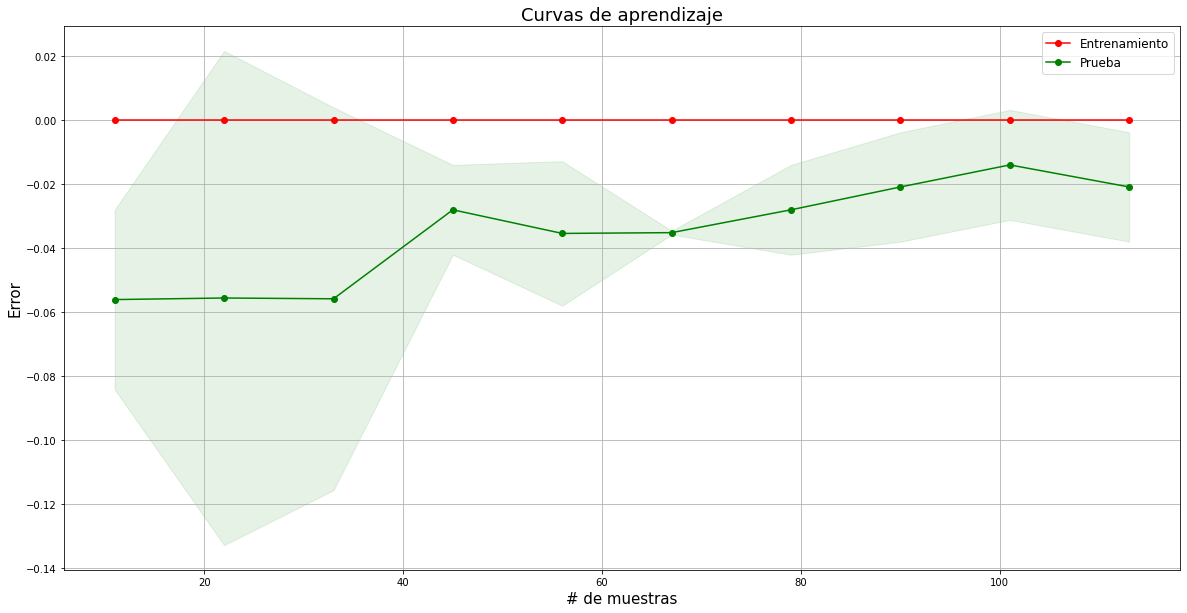

In [8]:
X = scaler.fit_transform(data.drop(columns=["Class"], axis=1))
y = data.Class.values

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

lr_refined = LogisticRegression()

avg_e_loss_refined, avg_bias_refined, avg_var_refined = bias_variance_decomp(lr_refined, X_train, y_train, X_test, y_test,
                                                                    loss="0-1_loss",
                                                                    num_rounds=200, random_seed=42)
results_new = pd.Series(data=[avg_e_loss_refined, avg_bias_refined, avg_var_refined],
                    index=["Error total promedio", "Sesgo promedio", "Varianza promedio"])

train_sizes, train_scores, test_scores, _, _ = learning_curve(lr_refined, X_train, y_train, return_times=True,
                                                                      train_sizes=np.linspace(0.1, 1.0, 10),
                                                                      scoring='neg_mean_squared_error')
figure = plt.figure()
figure.set_size_inches(20, 10)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.grid()
plt.fill_between(
    train_sizes,
    train_scores_mean - train_scores_std,
    train_scores_mean + train_scores_std,
    alpha=0.1,
    color="r",
)
plt.fill_between(
    train_sizes,
    test_scores_mean - test_scores_std,
    test_scores_mean + test_scores_std,
    alpha=0.1,
    color="g",
)
plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Entrenamiento")
plt.plot(train_sizes, test_scores_mean, "o-", color="g", label="Prueba")
plt.legend(loc="best", fontsize=12)
plt.xlabel("# de muestras", fontsize=15)
plt.ylabel("Error", fontsize=15)
plt.title("Curvas de aprendizaje", fontsize=18);

In [9]:
print(pd.DataFrame(results_new).T.to_string(index=False))

 Error total promedio  Sesgo promedio  Varianza promedio
              0.00625             0.0            0.00625


Como se puede observar en la grafica, el error en el set de entrenamiento se ha vuelto cero y el error del set de prueba ha disminuido en general. Tambien se puede observar como la linea de prueba se va lentamente acercando hacia la linea de entrenamiento mientras el numero de muestras va incrementando hasta estabilizarse alrededor de un error de -0.02, indicando que el modelo tiene un buen fit al dataset. Asimismo podemos confirmar lo que nos muestra la grafica con las calculaciones del error total, sesgo y varianza promedio, las cuales nos muestran como el error es muy bajo, el sesgo promedio es 0 y la varianza promedio tambien es muy baja.

## Parametros del modelo
Ya que se sabe cual es el mejor split de entrenamiento y prueba y las caracteristicas a utilizarse para el dataset se empezara a probar con diferentes parametros del modelo con el proposito de reducir aun mas la varianza y el sesgo e incrementar la precision simultaneamente. </br>
Para lograr esto, vamos a concentrarnos en 4 parametros del modelo de regresion logistica de Sklearn:
- solver : Algoritmo utilizado en la optimización
- C : Inverso de la fuerza de regularización
- max_iter : Número máximo de iteraciones necesarias para que los solucionadores converjan
- penalty : Especificar la norma del penalty

Con el proposito de facilitar la busqueda de estos parametros, se hara uso de un GridSearchCV para encontrar la mejor combinacion de parametros

In [10]:
params = {
    "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"],
    "C": np.logspace(-4, 4, 20),
    "max_iter": [100, 1000, 2500, 5000],
    "penalty": ["l1", "l2", "elasticnet", "none"],
    "verbose": [0]  # Silencia warnings, no afecta al rendimiento del modelo
}

lr = LogisticRegression()
warnings.filterwarnings("ignore")
clf = GridSearchCV(lr, param_grid=params, cv=3)

best_model = clf.fit(X_train, y_train)

In [11]:
print("Mejores parametros:", best_model.best_params_)

Mejores parametros: {'C': 0.08858667904100823, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg', 'verbose': 0}


Tras correr el GridSearchCV, este nos indica que, de los parametros que le dimos para probar, la mejor combinacion es la siguiente:
* penalty : l2
* solver : newton-cg
* max_iter : 100
* C : 0.08858667904100823

## Resultados y Conclusiones

### El mejor modelo (Refinado):
* Caracteristicas a utilizarze:
    * Cantidad de caracteristicas: 13
    * Caracteristicas:
        * Alcohol
        * Malic acid
        * Ash
        * Alcalinity of ash
        * Magnesium
        * Total phenols
        * Flavanoids
        * Nonflavanoid phenols
        * Proanthocyanins
        * Color intensity
        * Hue
        * OD280/OD315 of diluted wines
        * Proline
* Parametros relevantes por defecto de Regresion Lineal:
    * penalty = l2
    * solver = newton-cg
    * max_iter = 100
    * C = 0.08858667904100823

### Comparativa general de sesgo y varianza

<table><thead><tr><th></th><th>Sesgo</th><th>Varianza</th></tr></thead><tbody><tr><td>Base</td><td>Alto</td><td>Baja</td></tr><tr><td>Refinado</td><td>Bajo</td><td>Baja</td></tr></tbody></table>

In [12]:
lr_final = LogisticRegression(C=0.08858667904100823, max_iter=100, penalty="l2", solver="newton-cg")
lr_final.fit(X_train, y_train);

### Comparativa detallada de los modelos

In [14]:
accuracies = ["Precision", accuracy_score(y_test_, lr_base.predict(X_test_)), accuracy_score(y_test, lr_final.predict(X_test))]

avg_e_loss_new, avg_bias_new, avg_var_new = bias_variance_decomp(lr_final, X_train, y_train, X_test, y_test,
                                                                 loss="0-1_loss",
                                                                 num_rounds=200, random_seed=42)
errors = ["Error total esperado promedio", avg_e_loss_base, avg_e_loss_new]
biases = ["Sesgo promedio", avg_bias_base, avg_bias_new]
variances = ["Varianza promedio", avg_var_base, avg_var_new]

results = pd.DataFrame(data=[accuracies, errors, biases, variances], columns=["", "base", "refinado"])
print(results.T.to_string(header=False))


          Precision  Error total esperado promedio  Sesgo promedio  Varianza promedio
base       0.722222                       0.298426        0.296296           0.076759
refinado   0.972222                       0.006528             0.0           0.006528


Como se puede observar, al añadir mas caracteristicas, probar con diferentes tamaños de splits y probar con diferentes combinaciones de parametros el modelo mejora en varios aspectos. Al incrementar el tamaño del split de entrenamiento podemos reducir la varianza signficativamente y al añadir mas caracteristicas podemos reducir el sesgo aun mas.